In [1]:
""" 
*** Functions for tiling ***
"""
import math
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

# p = (RA, DEC)
def Equi2Cart(p):
    alpha = np.radians(p[0])
    delta = np.radians(p[1])
    x = np.cos(alpha) * np.cos(delta)
    y = np.sin(alpha) * np.cos(delta)
    z = np.sin(delta)
    return [x, y, z]
    # returns a vector in cartesian

# v = [x, y, z]
def Cart2Equi(v):
    x, y, z = v[0], v[1], v[2]
    ra = np.rad2deg(math.atan2(y,x))
    dec = np.rad2deg(math.asin(z))
    return [ra, dec]
    # returns a point in equitorial

# rotate about tile center
def rotate(angle):
    theta = np.radians(angle)
    Rx = [[1, 0, 0],
          [0, np.cos(theta), -np.sin(theta)],
          [0, np.sin(theta), np.cos(theta)]]
    return Rx

# move the center of the tile to the desired equatorial coordinates
def move(RA, DEC):
    alpha = np.radians(RA)
    delta = np.radians(DEC)
    # move to DEC coordinate
    Ry = [[np.cos(delta), 0, -np.sin(delta)],
          [0, 1, 0],
          [np.sin(delta), 0, np.cos(delta)]]
    # move to RA coordinate
    Rz = [[np.cos(alpha), -np.sin(alpha), 0],
          [np.sin(alpha), np.cos(alpha), 0],
          [0, 0, 1]]
    return np.matmul(Rz, Ry)

# coordinates of each CCD of the tile = [CCD1, CCD2, CCD3, CCD4]
def CCD_array(l=900/3600, w=860/3600, g=26/3600):
    RA = {1: g/2 + l, 2: g/2 + l, 3: g/2, 4: g/2, 5: g/2 + l, 6: g/2 + l, 7: g/2, 8: g/2, 
          9: -g/2, 10: -g/2, 11: -(g/2 + l), 12: -(g/2 + l), 13: -g/2, 14: -g/2, 15: -(g/2 + l), 16: -(g/2 + l)}
    DEC = {1: -(g/2 + w), 2: -g/2, 3: -g/2, 4: -(g/2 + w), 5: g/2, 6: g/2 + w, 7: g/2 + w, 8: g/2,
           9: g/2, 10: g/2 + w, 11: g/2 + w, 12: g/2, 13: -(g/2 + w), 14: -g/2, 15: -g/2, 16: -(g/2 + w)}
    tile = [[] for _ in range(4)]
    for i in range(1, 17):
        tile[(i - 1) // 4].append(Equi2Cart((RA[i],DEC[i])))
    return tile

# the projected length at a given declination 
def ProjDec(length, DEC):
    p = [length, 0]
    pp = Cart2Equi(np.matmul(move(0, DEC), Equi2Cart(p)))
    return pp[0]

# returns a tile multipolygon, the intersection ratio between the tile and footprint
def per_tile(footprint, RA, DEC, angle=0, l=900/3600, w=860/3600, g=26/3600):
    CCDs = []
    tile = CCD_array(l, w, g)
    inter_area = 0
    for CCD in tile:
        ra = []
        dec = []
        for i in range(4):
            # CCD[i] = (x, y, z) of each vertex of the CCD 
            CCD[i] = np.matmul(rotate(angle), CCD[i])
            CCD[i] = np.matmul(move(RA, DEC), CCD[i])
            x, y, z = CCD[i][0], CCD[i][1], CCD[i][2]
            # cartesian to equatorial 
            ra.append(np.rad2deg(math.atan2(y,x)))
            dec.append(np.rad2deg(math.asin(z)))
        ra.append(ra[0])
        dec.append(dec[0])
        # create polygon for each CCD in the CCD_array
        vertices = [(x, y) for x, y in zip(ra, dec)]
        polygon = Polygon(vertices)
        # each CCD's intersection with the footprint
        CCD_footprint = polygon.intersection(footprint)
        inter_area += CCD_footprint.area
        CCDs.append(polygon)
    # each tile is a multipolygon
    mp = MultiPolygon(CCDs)
    tile_area = mp.area  # each tile's area
    intersect_ratio = inter_area / tile_area
    return mp, intersect_ratio


### Tiling Strategy: Vertical Snake Scan

In [1]:
""" 
*** Vertical snake scan *** 
"""
def SnakeScanTiling(coords, min_intersect_ratio, tile_overlap=30/3600, l=900/3600, w=860/3600, g=26/3600):
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    #ax.plot(coords[:, 0], coords[:, 1], linewidth=0.8, color='black', label="footprint boundary")
    
    footprint = Polygon(coords)
    xmin, ymin, xmax, ymax = footprint.bounds
    
    # avoid computing tiles at the [-180, 180] boundary
    if xmin < -179.9:
        xmin = -179.9
    if xmax > 179.9:
        xmax = 179.9
    
    slew_length = (2*l + g) - tile_overlap
    slew_width = (2*w + g) - tile_overlap
    DECvals = np.arange(ymin+w, ymax+w, step=slew_width)
    
    # collect valid tile center coords in tiling sequence
    tile_centers = [] 
    RAvals = []
    max_length = 0 
    
    for DEC in DECvals:
        # calculate the RAs for a given DEC
        RArow = np.arange(xmin + ProjDec(l, DEC), xmax + ProjDec(l, DEC), step=ProjDec(slew_length, DEC))
        max_length = max(max_length, len(RArow))
        RAvals.append(RArow)
    
    # add NaN to make each row the same length
    for i in range(len(RAvals)):
        diff = max_length - len(RAvals[i])
        if diff > 0:
            RAvals[i] = np.append(RAvals[i], [math.nan]*diff)
    
    # transpose the tiling sequence from 'by rows' to 'by columns'
    RAvals = np.array(RAvals).T
    
    for n, RAcolumn in enumerate(RAvals):
        column = []
        for (RA, DEC) in zip(RAcolumn, DECvals):
            if np.isnan(RA) == False:
                tile_obj, intersect_ratio = per_tile(footprint, RA, DEC)
                if intersect_ratio >= min_intersect_ratio:
                    column.append((RA, DEC))
                    for geom in tile_obj.geoms:
                        xs, ys = geom.exterior.xy
                        ax.fill(xs, ys, alpha=0.5, color='royalblue', ec=None)
        # snake scan
        if n % 2 != 0:
            column = column[::-1]
        tile_centers.append(column)
    
    tile_centers = [j for i in tile_centers for j in i]
    tile_num = len(tile_centers)
    ax.plot(*zip(*tile_centers), linewidth=0.8, color='tab:red')
    ax.scatter(*zip(*tile_centers), s=5, color='black')
    
    return tile_centers

In [3]:
"""
*** Functions for tracking time and calculating observing efficiency ***
"""
import math 

# Find the angle (in degrees) between two points in equatorial coordinates (in deg)
def Haversine(p1, p2):
    ra1, dec1 = np.radians(p1[0]), np.radians(p1[1])
    ra2, dec2 = np.radians(p2[0]), np.radians(p2[1])
    theta12 = 2 * np.arcsin(np.sqrt(np.sin((dec2-dec1)/2)**2 + np.cos(dec1)*np.cos(dec2)*np.sin((ra2-ra1)/2)**2))
    return np.rad2deg(theta12)

def Angle2Time(theta):
    # Paul's Slew Angle vs. Slew Duration data
    slew_angle = np.array([0, 0.5, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 90, 90])
    slew_duration = np.array([30, 30, 66, 102, 138, 168, 198, 240, 276, 306, 336, 366, 414, 468])
    # linear interpolation --> interpolate slew time given the slew angle
    slew_time = np.interp(theta, slew_angle, slew_duration)
    return slew_time

def Seconds2Day(time):
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    return day, hour, minutes, seconds

# Convert time elapsed in an orbit (sec.) --> telescope's position (degrees) in an orbit around the Earth
# Angle theta starts in the East (viewed facing sun) going CCW; always between 0° to 360°
def Position(orbitTimeTrack):
    period = 100.9 # min
    # orbitTimeTrack is time elapsed from startAngle 
    theta = (orbitTimeTrack/60/period)*360 # degrees
    return theta

# the time passed (in sec.) while the telescope moves a given angle in the orbit
def PassedTime(angle):
    period = 100.9 # min
    return (angle/360)*period*60
    
# Viewing angle as a function of theta_b (in deg)
# theta_b: boresight angle as measured from CVZ center (angle away from CVZ center)
def ViewingFrac(theta_b):
    # Earth radius
    Re = 6378*1000 # m
    # satellite orbit altitude
    h = 800*1000 # m
    # Earth limb angle
    rho = math.degrees(math.asin(Re/(Re+h))) # deg
    # Earth exclusion angle
    epsilon = 10 # deg    
    # nu: satellite orbit position angle, measured from the X-axis
    # delta_nu: viewing angle (rad); symmetrical about the Y-axis
    if 0 <= theta_b <= 90-rho-epsilon:
        frac = 1
    else:
        delta_nu = math.pi + 2*math.asin(math.cos(math.radians(rho+epsilon)) / math.sin(math.radians(theta_b)))
        frac = math.degrees(delta_nu) / 360
    return frac

# With theta = 0° at positive RA (x-axis) direciton, (i.e. starts in the East viewed facing sun) going CCW
# satellite position = (x0, y0) where y0 = -7.8
# target = tile_center coords (x, y)
def ViewingZone(x0, target):
    y0 = -7.8
    x, y = target[0], target[1]
    xp = x - x0
    yp = y - y0
    # the direction where the boresight is pointing 
    theta = math.degrees(math.atan2(yp, xp))
    theta = (theta + 360) % 360
    # the angular distance the pointing is away from CVZ
    theta_b = math.sqrt(xp**2 + yp**2)
    #print('angle away from CVZ center:', theta_b)
    frac = ViewingFrac(theta_b)
    #print('viewing efficiency:', frac)
    halfVisAngle = frac*180 # degrees
    zone = [(theta-halfVisAngle+360)%360, (theta+halfVisAngle+360)%360]
    return zone

# Determine the types of viewing zone
def ZoneType(index, startzone, endzone):
    # three types of viewing zone
    if endzone-startzone > 10**-5:
        # the viewing zone is continuous, where startzone < endzone
        type = 1
        #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
    elif round(startzone,5) == round(endzone,5):
        # the tile is in CVZ
        type = 2
        #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
    else:
        # the viewing zone wraps around from 360° to 0° 
        type = 3
        #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, 360°] [0°, {round(endzone,4)}°] \033[0m")
    return type

def AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime):
    if startzone > theta:
        dead_time = PassedTime(startzone-theta+0.0001)
    else:
        dead_time = PassedTime(360-theta+startzone+0.0001)
    place_holder.append([dead_time, [theta, startzone+0.0001]])
    ElapsedTime += dead_time
    dayTimeTrack += dead_time
    weekTimeTrack += dead_time
    orbitTimeTrack += dead_time
    dataTimeTrack += dead_time
    DeadTime += dead_time
    # print('Dead time:', round(dead_time,2), 's')
    # print()
    return place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime

# Calculate how much time is available in the current viewing cycle
def TimeAvailable(type, endzone, theta): 
    if type==1:
        time_available = PassedTime(endzone-theta)
    elif type==2:
        time_available = PassedTime(360) # if the tile is in CVZ, there is infinite time available
    else:
        if endzone > theta:
            time_available = PassedTime(endzone-theta)
        else:
            time_available = PassedTime(360-theta+endzone)
    return time_available

# Update the time spend on moving to the tile and imaging
# need to specify which of the actions(slew, settle, and exposure) are included in this update
def Update4Imaging(slew, settle, Exposure, overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack):
    overhead_time += slew + settle
    exposure_time += Exposure
    SurveyTime += Exposure + slew + settle
    ElapsedTime += Exposure + slew + settle
    dayTimeTrack += Exposure + slew + settle
    weekTimeTrack += Exposure + slew + settle
    orbitTimeTrack += Exposure + slew + settle
    dataTimeTrack += Exposure + slew + settle
    return overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack

""" Time Trackers in the WideObserving code """
# Track Data
def TrackData(dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data):
    # Data Info
    px_amount = 8600 * 9000 * 4 * 3 # pixels
    byte_per_px = 2 # bytes
    data = (px_amount * byte_per_px)/10**9 # GB
    data_parts = data/4
    downlink_rate = 10/8 # GBps
    # max downlink window
    downlink_window = 5*60 # seconds
    downlink_max = downlink_rate * downlink_window # GB
    datacap = 440 # GB
    
    if dataTimeTrack >= 12*3600:
        #print('... Downlinking Data ...')
        #print()
        data_capacity = round((onboard_data/datacap)*100, 1)
        # data >= 375 GB
        if onboard_data >= downlink_max:
            downlink_time += downlink_window + 1*60
            SurveyTime += downlink_window + 1*60
            ElapsedTime += downlink_window + 1*60
            dayTimeTrack += downlink_window + 1*60
            weekTimeTrack += downlink_window + 1*60
            downlinked_data += downlink_max
            onboard_data -= downlink_max
        # data < 375 GB
        else:
            downlink_time += (onboard_data/downlink_rate) + 1*60
            SurveyTime += (onboard_data/downlink_rate) + 1*60
            ElapsedTime += (onboard_data/downlink_rate) + 1*60
            dayTimeTrack += (onboard_data/downlink_rate) + 1*60
            weekTimeTrack += (onboard_data/downlink_rate) + 1*60
            downlinked_data += onboard_data
            onboard_data = 0
        dataTimeTrack = 0 
    return dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data

# Track Orbit around Earth
def TrackOrbit(orbitTimeTrack, orbit_num):
    period = 100.9 # min
    # onto the the next orbit
    if orbitTimeTrack >= period*60:
        orbit_num += 1
        #print(f'{round(orbitTimeTrack/60,2)} min. passed --> entering new orbit')
        #print()
        orbitTimeTrack -= period*60
    return orbitTimeTrack, orbit_num

# Track Day: update satellite position across RA every day
def TrackDay(dayTimeTrack, day_num, sat_position, tile):
    daily_step = 360/365 # CVZ center movement across RA per day
    if dayTimeTrack >= 24*60*60:
        day_num += 1
        sat_position += daily_step
        # print()
        # print(f'\033[1m{round(dayTimeTrack/60/60,2)} hrs passed --> a new day\033[0m')
        # print(f"\033[1msatellite's RA = {sat_position}°\033[0m")
        # print(f'\033[1mviewing tiles on RA ~ {tile[0]}°\033[0m')
        # print()
        dayTimeTrack = 0
    return dayTimeTrack, day_num, sat_position

# Track Week: document information after every week
def TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week):
    if weekTimeTrack >= 604800:
        week_num += 1
        #print(f'{round(weekTimeTrack/60/60/24,2)} days passed --> a new week')
        #print()
        week[week_num] = tiles_per_week
        tiles_per_week = []
        if open_per_week == []:
            open_per_week.append(exposure_time)
            overhead_per_week.append(SurveyTime-exposure_time)
            dead_per_week.append(DeadTime)
        else:
            open_per_week.append(exposure_time - sum(open_per_week))
            overhead_per_week.append((SurveyTime - exposure_time) - sum(overhead_per_week))
            dead_per_week.append(DeadTime - sum(dead_per_week))
        weekTimeTrack -= 604800
    return weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week


#### TNO Deep Survey observing code
For a deep field, it calculates the observing efficiency "per visit" on each day.

In [4]:
from shapely.geometry import Polygon

""" TNO Deep Survey has exposure time of 300s per tile, 216 visits, doesn't have to be one per day"""
# Determines the total survey time required to complete one visit at a given day 
# (i.e. satellite's position relative to the target)
# day_range: the time window for completing the 216 visits; must be even number
def TNODeepObserving(footprint, day_range, exposure):
    tile_sequence = []
    # place_holder = [dead_time (s), telescope position range] 
    place_holder = [] # telescope position range = [start (deg), end (deg)]
    
    """ Imaging Requirement """
    gapfill = 30 #seconds
    settle = 90 #seconds
    
    """ Data Info """
    onboard_data = 0 #GB
    px_amount = 8600 * 9000 * 4 * 3 #pixels
    byte_per_px = 2 #bytes
    data = (px_amount * byte_per_px)/10**9 #GB
    
    """ Tracker """
    # all time are in seconds
    Exposure = 0
    Overhead = 0
    Deadtime = 0
    ElapsedTime = 0
    
    """ Info Per Visit """
    # total elapsed time
    TotalTimePerVisit = []
    # exposure time
    ExpoPerVisit = []
    # overhead
    OverPerVisit = []
    # dead time
    DeadPerVisit = []
    # efficiency = Exposure / ElapsedTime
    EffPerVisit = []
    # place holder
    PlaceHolderPerVisit = {}
    
    tile_centers = SnakeScanTiling(footprint, min_intersect_ratio=0.3)
    print(f'Survey consists of {len(tile_centers)} tiles')
    print()
    # tile index
    index = 0
    # day tracker
    # e.g. day_range = 30, start 15 days ahead of the tile
    day = -(day_range/2)
    
    """ Satellite Position """
    daily_step = 360/365 # CVZ center movement across RA per day
    xmin, ymin, xmax, ymax = Polygon(footprint).bounds
    centerRA = (xmin+xmax)/2
    minRA = centerRA - (day_range/2)*daily_step
    maxRA = centerRA + (day_range/2)*daily_step
    sat_position = np.arange(minRA, maxRA, daily_step)
    
    # Each day
    for x0 in sat_position:
        if day <= 0:
            print(f'\033[1m{abs(day)} days ahead\033[0m')
        else:
            print(f'\033[1m{day} days after\033[0m')
        #print(f"Satellite's RA = {x0}°")
        tiles = tile_centers[::-1] # copy the tiles in reverse order so target can be popped from the back
    
        # Assume that for each visit, the telescope is already at the startzone of the first tile
        zone = ViewingZone(x0, tiles[-1])
        startAngle = zone[0]+0.000001
        
        # Loop through all the tiles 
        while tiles:
            index += 1
            target = tiles.pop()
            
            theta = (Position(ElapsedTime) + startAngle) % 360
            #print(f'telescope position = {round(theta,4)}°')
    
            # Find the tile's viewing zone based on the satellite RA position 
            zone = ViewingZone(x0, target)
            startzone, endzone = zone[0], zone[1]
            # three types of viewing zone
            if endzone-startzone > 10**-8:
                # the viewing zone is continuous, where startzone < endzone
                scenario = 1
                #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
            elif round(startzone,7) == round(endzone,7):
                # the tile is in CVZ
                scenario = 2
                #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
            else:
                # the viewing zone wraps around from 360° to 0° 
                scenario = 3
                #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, 360°] [0°, {round(endzone,4)}°] \033[0m")
            
            # In viewing zone
            if (scenario==1 and startzone<=theta<=endzone) or scenario==2 or (scenario==3 and (startzone<=theta<=360 or 0<=theta<=endzone)):
                # Calculate how much time is left in this viewing cycle
                if scenario==1:
                    time_available = PassedTime(endzone-theta)
                elif scenario==2:
                    time_available = PassedTime(360)
                else:
                    if endzone > theta:
                        time_available = PassedTime(endzone-theta)
                    else:
                        time_available = PassedTime(360-theta+endzone)
                
                time_used = 0
                if index == 1:
                    time_used = 2*gapfill
                else:
                    angle = Haversine(tile_sequence[-1], target)
                    slew = Angle2Time(angle)
                    time_used = slew + settle + 2*gapfill 
                time_left = time_available - time_used
                #print(f'time left in this viewing cycle: {round(time_left,4)}s')
                
                # Enough time -> image the tile
                if time_left >= exposure:
                    # Slew to the tile
                    if index != 1:
                        #print('slew + settle takes', slew + settle, 's')
                        Overhead += slew + settle
                        ElapsedTime += slew + settle
                    # Fully image the tile
                    #print(f'Image tile {index}')
                    tile_sequence.append(target)
                    Exposure += exposure
                    ElapsedTime += exposure
                    onboard_data += data
                # Not enough time -> deadtime
                else:
                    tiles.append(target)
                    index -= 1
                    if scenario == 1:
                        dead_time = PassedTime(360-theta+startzone+0.0001) # in seconds
                    else:
                        if startzone > theta: 
                            dead_time = PassedTime(startzone-theta+0.0001)
                        else:
                            dead_time = PassedTime(360-theta+startzone+0.0001)
                    place_holder.append([dead_time, [theta, startzone+0.0001]])
                    #print('\033[1mdeadtime :\033[0m', place_holder[-1])
                    Deadtime += dead_time
                    ElapsedTime += dead_time
                    continue 
            # Not in viewing zone -> deadtime
            else:
                print('Should NOT happen since each visit starts in the viewing zone')
                tiles.append(target)
                index -= 1
                if startzone > theta:
                    dead_time = PassedTime(startzone-theta+0.0001)
                else:
                    dead_time = PassedTime(360-theta+startzone+0.0001)
                place_holder.append([dead_time, [theta, startzone+0.0001]])
                #print('\033[1mdeadtime :\033[0m', place_holder[-1])
                Deadtime += dead_time
                ElapsedTime += dead_time
            #print()
        
        #After all tiles are completed
        print('========================================================')
        print('Total Elapsed Time = exposure + overhead + deadtime')
        time = Seconds2Day(ElapsedTime)
        print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec')
        # print('Exposure:')
        # time = Seconds2Day(Exposure)
        # print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec')
        # print('Overhead:')
        # time = Seconds2Day(Overhead)
        # print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec')
        # print('Deadtime:')
        # time = Seconds2Day(Deadtime)
        # print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec')
        
        Efficiency = (Exposure / ElapsedTime)*100
        print(f'Observing Efficiency: {round(Efficiency,2)}%')
        #print(f'Data accumulated: {round(onboard_data,2)} GB')
        print('========================================================')
        print()

        TotalTimePerVisit.append(ElapsedTime)
        ExpoPerVisit.append(Exposure)
        OverPerVisit.append(Overhead)
        DeadPerVisit.append(Deadtime)
        EffPerVisit.append(Efficiency)
        PlaceHolderPerVisit[day] = place_holder
    
        Exposure = 0
        Overhead = 0
        Deadtime = 0
        place_holder = []
        
        index = 0
        ElapsedTime = 0
        theta = startAngle
        day += 1

    return TotalTimePerVisit, EffPerVisit, PlaceHolderPerVisit, onboard_data


#### TNO Wide Survey observing code
The Wide Survey is divided up into sections spanning 'section_range' in RA. \
It calculates the observing efficiency of each section, starting observation 'days_after' the left-most tile in the seciton.

In [30]:
""" TNO Wide Survey has exposure time of 3x300s per tile """
# Has to be a continuous 900s because science team requires first and third sub-exposure to be 600s apart

# Input the section
# e.g. each section spans 30° in RA, and will start the observation 15 days after the left-most tile in the section. 
def TNOWideObserving(section, section_range, days_after, startAngle, exposure, settle=90):
        
    tile_sequence = [] # a list of tile coordinates in their imaging order
    # should end up being the same as tile_centers
    
    # place_holder = [dead_time (s), telescope position range] 
    place_holder = [] # telescope position range = [start (deg), end (deg)]
    
    """ Imaging Requirement """
    px_amount = 8600 * 9000 * 4 * 3 # pixels
    byte_per_px = 2 # bytes
    data = (px_amount * byte_per_px)/10**9 # GB
    
    # all time are in seconds if not specified
    """ Time Tracker """
    dayTimeTrack = 0
    weekTimeTrack = 0
    orbitTimeTrack = 0
    dataTimeTrack = 0 
    DeadTime = 0
    SurveyTime = 0
    ElapsedTime = 0
    
    """ Info Tracker """
    overhead_time = 0
    exposure_time = 0
    downlink_time = 0 
    onboard_data = 0 # GB
    downlinked_data = 0 # GB
    orbit_num = 0
    day_num = 0
    week_num = 0
    # a list of tile coords in their imaging order in the week
    tiles_per_week = []
    # a list of open-shutter time accumulated per week
    open_per_week = [] 
    # a list of overheads accumulated per week 
    overhead_per_week = []
    # a list of deadtimes accumulated per week
    dead_per_week = [] 
    # a dictionary with key: week_num, value: tiles_per_week
    week = {} 

    # tile index
    index = 1

    print(f"section's RA range: {section_range}")
    print(f'containing {len(section)} tiles')
    
    # start the satellite's RA position "days_after" the left-most tile of each section
    daily_step = 360/365 # CVZ center movement across RA per day
    sat_position = section[0][0] + days_after*daily_step
    start_sat = sat_position
    print(f"\033[1msatellite's starting RA = {start_sat}°\033[0m")
    
    """ BEGIN OBSERVING HERE: going through all the tiles in this section """
    while section:
        # Update telescope position
        theta = (Position(orbitTimeTrack) + startAngle) % 360
        #print(f'telescope position around Earth = {round(theta,4)}°')

        # Select a tile in the order of the vertical snake scan
        tile = section.pop(0)

        # Find the tile's viewing zone based on the satellite RA position 
        zone = ViewingZone(sat_position, tile)
        startzone, endzone = zone[0], zone[1]
        type = ZoneType(index, startzone, endzone)

        # When the telescope is NOT in the selected tile's viewing zone, WAIT until it is in the zone
        if not((type==1 and startzone<=theta<=endzone) or type==2 or (type==3 and (startzone<=theta<=360 or 0<=theta<=endzone))):
            """ Add dead time """
            place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
            theta = (Position(orbitTimeTrack) + startAngle) % 360
            #print(f'telescope position around Earth = {round(theta,4)}°')
        
        """ Track Orbit """
        orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
        """ Track Day """
        dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, tile)
        """ Track Week """
        weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

        # When the telescope IS in the selected tile's viewing zone, allow imaging
        # But first, check if there's enough time left to complete at least one exposure segment 
        time_available = TimeAvailable(type, endzone, theta)
        time_used = 0
        if index != 1:
            angle = Haversine(tile_sequence[-1], tile)
            slew = Angle2Time(angle)
            time_used = slew + settle
        time_left = time_available - time_used

        # Not enough time
        if time_left < exposure:
            #print(f'time available for imaging in this orbit: {round(time_left,4)}s, NOT enough time')
            section = [tile] + section    
            """ Add dead time """
            place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
            continue # go straight to the next "while loop" iteration
        
        # Enough time
        else:
            # Slew to the tile
            if index != 1:
                #print('slew + settle takes', slew + settle, 's')
                """ Update Time - moving to the tile """
                overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(slew, settle, 0, overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
                
            #print(f'time available for imaging in this orbit: {round(time_left,4)}s, enough time')
            #print()
            tile_sequence.append(tile)
            tiles_per_week.append(tile)
            # Complete imaging
            #print('*** IMAGING ***')
            #print('Exposure =', exposure, 's')
            """ Update Time - imaging tile """
            overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(0, 0, exposure, overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
            #print(f'<< tile {index} COMPLETED >>')
            # the index for the next tile
            index += 1
            #print('going to tile', index)
            #print()

        """ Track Data """
        dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data = TrackData(dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data)
        """ Track Orbit """
        orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
        """ Track Day """
        dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, tile)
        """ Track Week """
        weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

    # When all tiles in the section are completed
    end_sat = sat_position
    print(f"\033[1msatellite's ending RA = {end_sat}°\033[0m")
    sat_range = (start_sat, end_sat) # the RA range that the satellite moved while completing the section
    index -= 1
    #print(f'{index} tiles successfully imaged')
    print('currently on orbit', orbit_num+1, 'around Earth')
    print()
    # From the last incomplete week / orbit
    week[week_num+1] = tiles_per_week
    open_per_week.append(exposure_time - sum(open_per_week))
    overhead_per_week.append((SurveyTime - exposure_time) - sum(overhead_per_week))
    dead_per_week.append(DeadTime - sum(dead_per_week))
    
    # print('\033[1mexposure time:\033[0m', exposure_time, 's')  
    # print('\033[1mSurvey Time\033[0m = exposure + overheads')
    # print(Seconds2Day(SurveyTime))
    print('\033[1mTotal Elapsed Time\033[0m = survey + deadtime')
    print(Seconds2Day(ElapsedTime))
    TotalDeadTime = ElapsedTime - SurveyTime
    Efficiency = (exposure_time / ElapsedTime)*100
    print(f'\033[1mObserving Efficiency: \033[0m{round(Efficiency,2)}%')
    print(f'\033[1mTotal dead time: \033[0m{round(TotalDeadTime/3600,2)} hrs')
    print()
    # print(f'Data onboard: {round(onboard_data,2)} GB')
    # print(f'Data downlinked: {round(downlinked_data,2)} GB')
    
    return sat_range, tile_sequence, place_holder, open_per_week, overhead_per_week, dead_per_week, week, Efficiency

In [8]:
""" 
*** Functions for survey coordinates and plots ***
"""

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon

def PlotTile(center_coords, colors):
    RA, DEC = center_coords[0], center_coords[1]
    tile = CCD_array()
    for CCD in tile:
        ra = []
        dec = []
        for i in range(4):
            # CCD[i] = (x, y, z) of each vertex of the CCD 
            CCD[i] = np.matmul(rotate(0), CCD[i])
            CCD[i] = np.matmul(move(RA, DEC), CCD[i])
            x, y, z = CCD[i][0], CCD[i][1], CCD[i][2]
            # cartesian to equatorial 
            ra.append(np.rad2deg(math.atan2(y,x)))
            dec.append(np.rad2deg(math.asin(z)))
        ra.append(ra[0])
        dec.append(dec[0])
        ax.fill(ra, dec, alpha=0.2, color=colors, ec=colors)

def normalize_ra(ra):
    # Normalize RA values to the range [-180, 180] degrees.
    while ra >= 180:
        ra -= 360
    while ra < -180:
        ra += 360
    return ra

def TNOdeep_Footprint(tlx, tly):
    # 4x6 grid, 24 tiles; total area of ~6 deg^2
    L = (900*2+26)/3600 * 4 # deg
    W = (800*2+26)/3600 * 6 # deg
    return np.array([[tlx, tly], [tlx+L, tly], [tlx+L, tly-W], [tlx, tly-W], [tlx, tly]])

# TNO Wide Survey coordinates
TNOWide_coords = np.loadtxt('TNO_wide.txt', skiprows=2) 
TNOWide_coords = np.concatenate((TNOWide_coords[:23], np.flipud(TNOWide_coords[23:]), [TNOWide_coords[0]]), axis=0)
TNOWide_coords[:, 0] = np.vectorize(normalize_ra)(TNOWide_coords[:, 0])

⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆
### TNO Deep Survey
Tiling strategy per deep field: vertical snake scan. \
For each deep field, it calculates the observing efficiency per visit on a given day in 'day_range'.

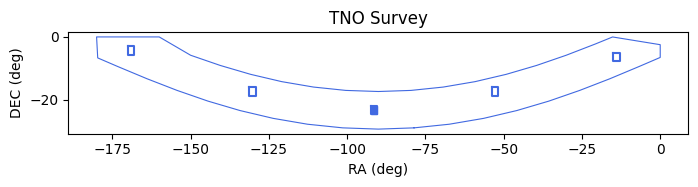

Survey consists of 24 tiles

15.0 days ahead
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 3.0 hr, 37.0 min, 34.06190683267778 sec
Observing Efficiency: 55.16%

14.0 days ahead
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 3.0 hr, 37.0 min, 38.688601365074646 sec
Observing Efficiency: 55.14%

13.0 days ahead
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 3.0 hr, 37.0 min, 43.25883010170219 sec
Observing Efficiency: 55.12%

12.0 days ahead
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 3.0 hr, 31.0 min, 0.3491110496324836 sec
Observing Efficiency: 56.87%

11.0 days ahead
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 3.0 hr, 31.0 min, 9.238860326293434 sec
Observing Efficiency: 56.83%

10.0 days ahead
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 3.0 hr, 6.0 min, 36.51529667466821 sec
Observing Efficiency: 64.31%

9.0 days ahead
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 3.0 hr, 6.0 

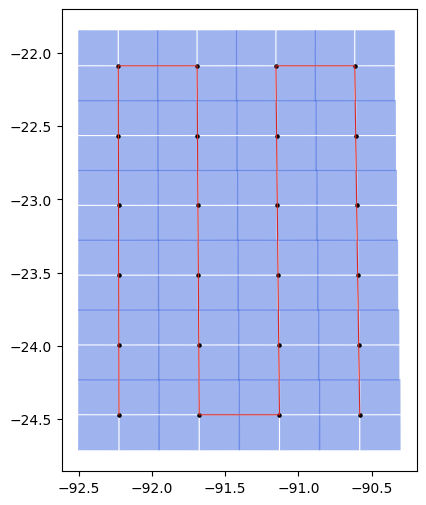

In [10]:
""" TNO DEEP SURVEY: five 4x6 deep footprint """

""" Choose which of the five fields to view """
i = 3 # field index from 1 to 5

# Acquire and plot the five TNO Deep footprint
TNODeep_coords = []
footprint = Polygon(TNOWide_coords)
xmin, ymin, xmax, ymax = footprint.bounds
xDeep = np.linspace(xmin+10, xmax-15, 5)
yDeep = [-3, -16, -22, -16, -5]

# Plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_aspect(1)
ax.plot(TNOWide_coords[:, 0], TNOWide_coords[:, 1], linewidth=0.8, color='royalblue', label="footprint boundary")
for x, y in zip(xDeep, yDeep):
    ax.plot(*zip(*TNOdeep_Footprint(x, y)), color='royalblue')
    TNODeep_coords.append(TNOdeep_Footprint(x, y))
ax.fill(*zip(*TNOdeep_Footprint(xDeep[i-1], yDeep[i-1])), color='royalblue')
plt.xlabel('RA (deg)', fontsize=10)
plt.ylabel('DEC (deg)', fontsize=10)
plt.title('TNO Survey', fontsize=12)
plt.show()

# Calculate the observing efficiency per visit
footprint = np.array(TNODeep_coords[i-1])
day_range = 30
TotalTimePerVisit, EffPerVisit, PlaceHolderPerVisit, onboard_data = TNODeepObserving(footprint, day_range, exposure=300)

# Determine the number of visits completed per day in the day_range
print(f'\033[1mField {i}\033[0m')
total_hr = np.array(TotalTimePerVisit)/60/60
print('Hours spent per visit per day')
print(total_hr)
visit_num = np.floor(24/total_hr)
print('Number of visits complete per day')
print(visit_num)
print(f'{sum(visit_num)} total visits in {len(visit_num)} days')

⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆
### TNO Wide Survey
Tiling strategy: vertical snake scan. \
Calculates the observing efficiency for each section. 

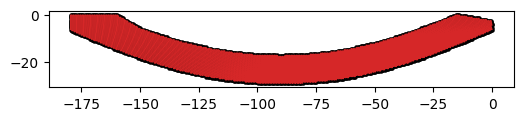

In [13]:
""" TNO WIDE SURVEY: divided into five sections to complete """

# Section the TNO Wide into groups, each spanning an RA range of group_size.
def SectionTNOWide(tile_centers, group_size=30):
    min_ra, max_ra = tile_centers[0][0], tile_centers[-1][0]
    group_num = int((max_ra - min_ra) // group_size + 1)
    group_range = [] 
    start = min_ra
    for i in range(group_num):
        end = start + group_size
        group_range.append([start, end])
        start = end
    groups = [[] for _ in range(group_num)]
    for tile in tile_centers:
        tile_ra = tile[0]
        for i, (start, end) in enumerate(group_range):
            if start <= tile_ra < end:
                groups[i].append(tile)
                break  
    return groups, group_range

# Determine all the tiles in the TNO Wide Survey
tile_centers = SnakeScanTiling(TNOWide_coords, min_intersect_ratio=0.3)

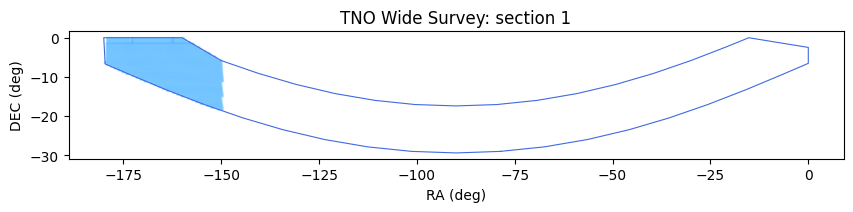

section's RA range: [-179.64847083671617, -149.64847083671617]
containing 1500 tiles
satellite's starting RA = -169.78545713808603°
satellite's ending RA = -153.0183338504148°
currently on orbit 253 around Earth

Total Elapsed Time = survey + deadtime
(17.0, 17.0, 35.0, 22.904903677525)
Observing Efficiency: 88.11%
Total dead time: 0.0 hrs



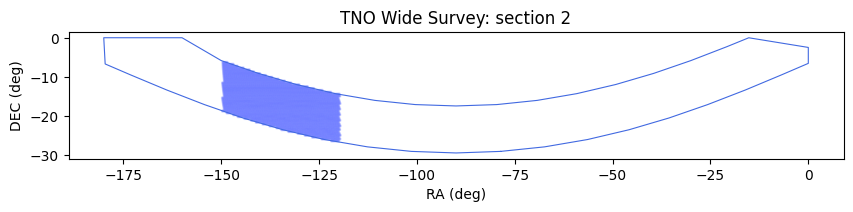

section's RA range: [-149.64847083671617, -119.64847083671617]
containing 1527 tiles
satellite's starting RA = -137.77645943594263°
satellite's ending RA = -120.02303477840837°
currently on orbit 259 around Earth

Total Elapsed Time = survey + deadtime
(18.0, 2.0, 52.0, 49.06012507644482)
Observing Efficiency: 87.78%
Total dead time: 1.59 hrs



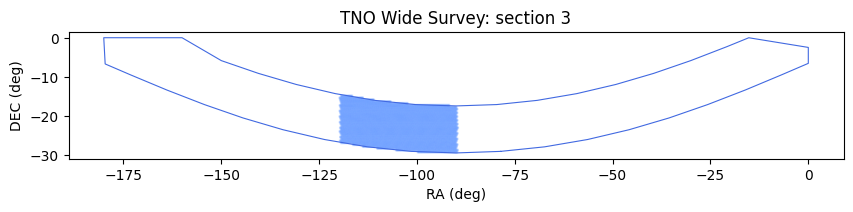

section's RA range: [-119.64847083671617, -89.64847083671617]
containing 1430 tiles
satellite's starting RA = -111.35644129713415°
satellite's ending RA = -93.6030166395999°
currently on orbit 262 around Earth

Total Elapsed Time = survey + deadtime
(18.0, 7.0, 45.0, 42.11346886586398)
Observing Efficiency: 81.29%
Total dead time: 33.67 hrs



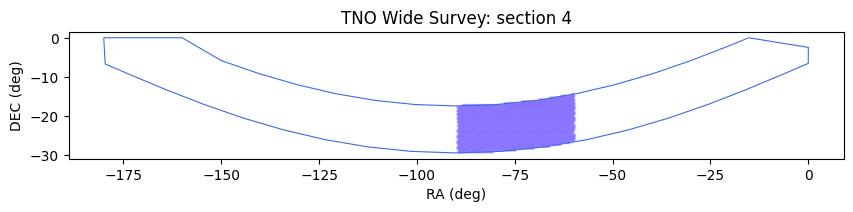

section's RA range: [-89.64847083671617, -59.64847083671617]
containing 1431 tiles
satellite's starting RA = -82.40970776047985°
satellite's ending RA = -64.6562831029456°
currently on orbit 263 around Earth

Total Elapsed Time = survey + deadtime
(18.0, 9.0, 18.0, 11.462738271337003)
Observing Efficiency: 81.07%
Total dead time: 34.51 hrs



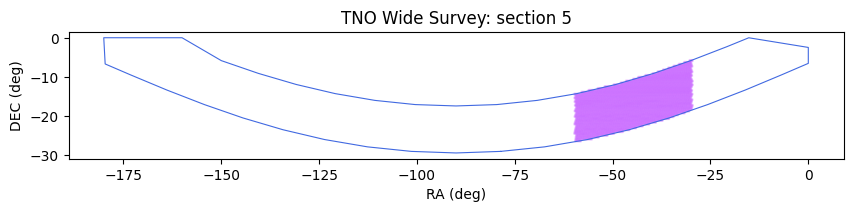

section's RA range: [-59.64847083671617, -29.64847083671617]
containing 1532 tiles
satellite's starting RA = -55.43130157501923°
satellite's ending RA = -37.67787691748498°
currently on orbit 260 around Earth

Total Elapsed Time = survey + deadtime
(18.0, 4.0, 9.0, 41.337654231349006)
Observing Efficiency: 87.81%
Total dead time: 0.78 hrs



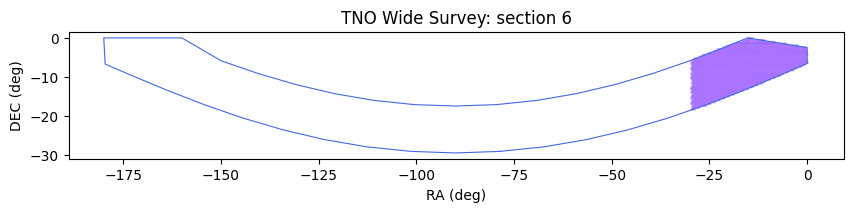

section's RA range: [-29.64847083671617, 0.35152916328382844]
containing 1341 tiles
satellite's starting RA = -26.449454404941378°
satellite's ending RA = -11.654933856996166°
currently on orbit 227 around Earth

Total Elapsed Time = survey + deadtime
(15.0, 20.0, 38.0, 10.907188151264563)
Observing Efficiency: 88.08%
Total dead time: 0.0 hrs

Time between section 1 and 2: 15.45 days
Time between section 2 and 3: 8.79 days
Time between section 3 and 4: 11.35 days
Time between section 4 and 5: 9.35 days
Time between section 5 and 6: 11.38 days


In [33]:
""" Pick a section to view, index from 1 to 6 """
# i = 6 # section index

# optimal 'days_after' for each section (doesn't really matter for section 1 and 6)
best_days_after = [10, 12, 8, 7, 4, 3]

# info for caculating the time gap between sections
start = []
end = []

# Loop through each section 
for i in range(1,7):
    # 'group_size' is the RA length of each section
    groups, group_range = SectionTNOWide(tile_centers, group_size=30)
    section = groups[i-1]
    section_range = group_range[i-1]
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.plot(TNOWide_coords[:, 0], TNOWide_coords[:, 1], linewidth=0.8, color='royalblue', label="footprint boundary")
    color_scheme = ['#45B4FF', '#4557FF', '#4586FF', '#6145FF', '#BF45FF', '#9045FF']
    color = color_scheme[i-1]
    for tile in section:
        PlotTile(tile, colors=color)
    ax.set_xlabel('RA (deg)', fontsize=10)
    ax.set_ylabel('DEC (deg)', fontsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(f'TNO Wide Survey: section {i}')
    plt.show()
    
    # Determine the observing efficiency
    days_after = best_days_after[i-1] # when to observe each section
    startAngle = 0
    exposure = 900
    sat_range, tile_sequence, place_holder, open_per_week, overhead_per_week, dead_per_week, week, Efficiency = TNOWideObserving(section, section_range, days_after, startAngle, exposure)

    # For each section
    start_sat, end_sat = sat_range[0], sat_range[1]
    start.append(start_sat)
    end.append(end_sat)
    
# Determine the time in-between the sections
for j in range(5):
    gap_deg = start[j+1] - end[j]
    gap_day = gap_deg * (365/360)
    print(f'Time between section {j+1} and {j+2}: {round(gap_day,2)} days')


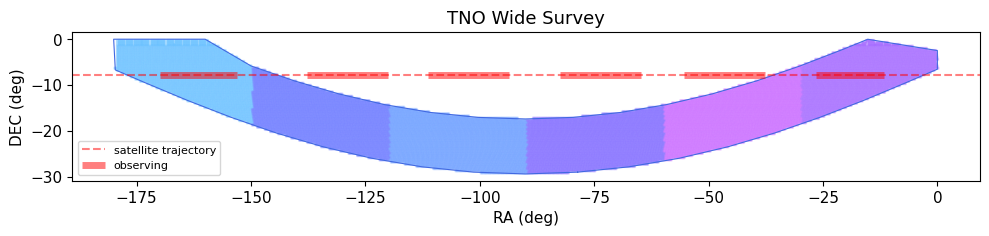

In [57]:
import numpy as np 
import matplotlib.pyplot as plt

groups, group_range = SectionTNOWide(tile_centers, group_size=30)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_aspect(1)
# TNO Wide footprint boundary
ax.plot(TNOWide_coords[:, 0], TNOWide_coords[:, 1], linewidth=0.8, color='royalblue')
color_scheme = ['#45B4FF', '#4557FF', '#4586FF', '#6145FF', '#BF45FF', '#9045FF']
# tiles in each section
for i, group in enumerate(groups):
    color = color_scheme[i]
    for tile in group:
        PlotTile(tile, colors=color)
# satellite movement when imaging each section
plt.axhline(y=-7.8, linestyle='--', color='red', alpha=0.5, label='satellite trajectory')
for j in range(5):
    # the section when satellite is imaging TNO Wide survey
    ax.hlines(y=-7.8, xmin=start[j], xmax=end[j], linewidth=5, color='red', alpha=0.5)
ax.hlines(y=-7.8, xmin=start[-1], xmax=end[-1], linewidth=5, color='red', alpha=0.5, label='observing')
ax.set_xlabel('RA (deg)', fontsize=11)
ax.set_ylabel('DEC (deg)', fontsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.set_title('TNO Wide Survey', fontsize=13)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('sections.pdf')

⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆.˚⭒⋆.˚⋆

In [68]:
""" An example for imaging the entire wide survey at once, with no sections """
# Has to be a continuous 900s because science team requires first and third sub-exposure to be 600s apart

def TNOWideObserving(coords, days_after, startAngle, exposure, settle=90):
        
    tile_sequence = [] # a list of tile coordinates in their imaging order
    # should end up being the same as tile_centers
    
    # place_holder = [dead_time (s), telescope position range] 
    place_holder = [] # telescope position range = [start (deg), end (deg)]
    
    """ Imaging Requirement """
    px_amount = 8600 * 9000 * 4 * 3 # pixels
    byte_per_px = 2 # bytes
    data = (px_amount * byte_per_px)/10**9 # GB
    
    # all time are in seconds if not specified
    """ Time Tracker """
    dayTimeTrack = 0
    weekTimeTrack = 0
    orbitTimeTrack = 0
    dataTimeTrack = 0 
    DeadTime = 0
    SurveyTime = 0
    ElapsedTime = 0
    
    """ Info Tracker """
    overhead_time = 0
    exposure_time = 0
    downlink_time = 0 
    onboard_data = 0 # GB
    downlinked_data = 0 # GB
    orbit_num = 0
    day_num = 0
    week_num = 0
    # a list of tile coords in their imaging order in the week
    tiles_per_week = []
    # a list of open-shutter time accumulated per week
    open_per_week = [] 
    # a list of overheads accumulated per week 
    overhead_per_week = []
    # a list of deadtimes accumulated per week
    dead_per_week = [] 
    # a dictionary with key: week_num, value: tiles_per_week
    week = {} 

    # tile index
    index = 1
    tile_centers = SnakeScanTiling(coords, min_intersect_ratio=0.3)
    
    # start the satellite's RA position "days_after" the left-most tile of the wide survey
    daily_step = 360/365 # CVZ center movement across RA per day
    sat_position = tile_centers[0][0] + days_after*daily_step
    start_sat = sat_position
    print(f"\033[1msatellite's starting RA = {start_sat}°\033[0m")
    
    """ BEGIN OBSERVING HERE: going through all the tiles """
    while tile_centers:
        # Update telescope position
        theta = (Position(orbitTimeTrack) + startAngle) % 360
        #print(f'telescope position around Earth = {round(theta,4)}°')

        # Select a tile in the order of the vertical snake scan
        tile = tile_centers.pop(0)

        # Find the tile's viewing zone based on the satellite RA position 
        zone = ViewingZone(sat_position, tile)
        startzone, endzone = zone[0], zone[1]
        type = ZoneType(index, startzone, endzone)

        # When the telescope is NOT in the selected tile's viewing zone, WAIT until it is in the zone
        if not((type==1 and startzone<=theta<=endzone) or type==2 or (type==3 and (startzone<=theta<=360 or 0<=theta<=endzone))):
            """ Add dead time """
            place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
            theta = (Position(orbitTimeTrack) + startAngle) % 360
            #print(f'telescope position around Earth = {round(theta,4)}°')
        
        """ Track Orbit """
        orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
        """ Track Day """
        dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, tile)
        """ Track Week """
        weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

        # When the telescope IS in the selected tile's viewing zone, allow imaging
        # But first, check if there's enough time left to complete at least one exposure segment 
        time_available = TimeAvailable(type, endzone, theta)
        time_used = 0
        if index != 1:
            angle = Haversine(tile_sequence[-1], tile)
            slew = Angle2Time(angle)
            time_used = slew + settle
        time_left = time_available - time_used

        # Not enough time
        if time_left < exposure:
            #print(f'time available for imaging in this orbit: {round(time_left,4)}s, NOT enough time')
            tile_centers = [tile] + tile_centers    
            """ Add dead time """
            place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
            continue # go straight to the next "while loop" iteration
        
        # Enough time
        else:
            # Slew to the tile
            if index != 1:
                #print('slew + settle takes', slew + settle, 's')
                """ Update Time - moving to the tile """
                overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(slew, settle, 0, overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
                
            #print(f'time available for imaging in this orbit: {round(time_left,4)}s, enough time')
            #print()
            tile_sequence.append(tile)
            tiles_per_week.append(tile)
            # Complete imaging
            #print('*** IMAGING ***')
            #print('Exposure =', exposure, 's')
            """ Update Time - imaging tile """
            overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(0, 0, exposure, overhead_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
            #print(f'<< tile {index} COMPLETED >>')
            # the index for the next tile
            index += 1
            #print('going to tile', index)
            #print()

        """ Track Data """
        dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data = TrackData(dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data)
        """ Track Orbit """
        orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
        """ Track Day """
        dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, tile)
        """ Track Week """
        weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

    # When all tiles are completed
    end_sat = sat_position
    print(f"\033[1msatellite's ending RA = {end_sat}°\033[0m")
    sat_range = (start_sat, end_sat) # the RA range that the satellite moved while completing the survey
    index -= 1
    print(f'{index} tiles successfully imaged')
    print('currently on orbit', orbit_num+1, 'around Earth')
    print()
    # From the last incomplete week / orbit
    week[week_num+1] = tiles_per_week
    open_per_week.append(exposure_time - sum(open_per_week))
    overhead_per_week.append((SurveyTime - exposure_time) - sum(overhead_per_week))
    dead_per_week.append(DeadTime - sum(dead_per_week))
    
    print('\033[1mexposure time:\033[0m', exposure_time, 's')  
    # print('\033[1mSurvey Time\033[0m = exposure + overheads')
    # print(Seconds2Day(SurveyTime))
    print('\033[1mTotal Elapsed Time\033[0m = survey + deadtime')
    print(Seconds2Day(ElapsedTime))
    TotalDeadTime = ElapsedTime - SurveyTime
    Efficiency = (exposure_time / ElapsedTime)*100
    print(f'\033[1mObserving Efficiency: \033[0m{round(Efficiency,2)}%')
    print(f'\033[1mTotal dead time: \033[0m{round(TotalDeadTime/3600,2)} hrs')
    print()
    # print(f'Data onboard: {round(onboard_data,2)} GB')
    # print(f'Data downlinked: {round(downlinked_data,2)} GB')
    
    return sat_range, tile_sequence, place_holder, open_per_week, overhead_per_week, dead_per_week, week, Efficiency

satellite's starting RA = -159.9224434394559°
satellite's ending RA = -31.70326535726406°
8774 tiles successfully imaged
currently on orbit 1871 around Earth

exposure time: 7896600 s
Total Elapsed Time = survey + deadtime
(131.0, 5.0, 1.0, 5.96085193566978)
Observing Efficiency: 69.66%
Total dead time: 656.72 hrs



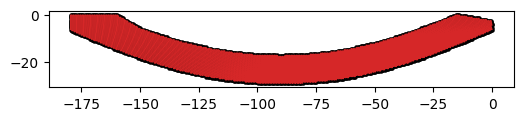

In [67]:
days_after = 20
startAngle = 0
exposure = 900
sat_range, tile_sequence, place_holder, open_per_week, overhead_per_week, dead_per_week, week, Efficiency = TNOWideObserving(TNOWide_coords, days_after, startAngle, exposure, settle=90)
